MODEL HALAL STOCK

In [53]:
from cassandra.cluster import Cluster
import pandas as pd
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

Connect to Data base for import Data

In [54]:
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('info_stock')

In [55]:
rows = session.execute('SELECT * FROM financial_data')
df = pd.DataFrame(rows.all())

In [56]:
df.head(3)

,ticker,industry,interest_income,long_business_summary,name,sector,total_assets,total_debt,total_revenue
0,SIAM.BK,"Furnishings, Fixtures & Appliances",-0.02879,Siam Steel International Public Company Limite...,SIAM_SIAM STEEL INTERNATIONAL,Consumer Cyclical,1.0,2.040780e+08,1.773048e+09
1,KAMART.BK,Household & Personal Products,0.27538,"Karmarts Public Company Limited, together with...",KAMART_KARMARTS,Consumer Defensive,1.0,6.533160e+08,3.322751e+09
2,IFS.BK,Credit Services,0.40719,IFS Capital (Thailand) Public Company Limited ...,IFS_IFS CAPITAL (THAILAND),Financial Services,1.0,2.237478e+09,4.514385e+08


In [57]:
df.shape

(921, 9)

In [58]:
df.columns

Index(['ticker', 'industry', 'interest_income', 'long_business_summary',
       'name', 'sector', 'total_assets', 'total_debt', 'total_revenue'],
      dtype='object')

In [59]:
df = df.drop(columns=['interest_income','total_assets', 'total_debt', 'total_revenue'])

Vocab about haram

In [60]:
# ✅ Vocab ที่คุณให้ไว้
vocab = {
    "Interest": {
        "Finance": [
            "interest rate", "compound interest", "loan", "mortgage", "investment"
        ],
        "Emotion": [
            "curiosity", "fascination", "passion", "hobby", "engagement"
        ]
    },
    "Gambling": [
        "bet", "wager", "casino", "odds", "jackpot", "addiction",
        "high roller", "roulette", "poker", "blackjack", "slot machine"
    ],
    "Pigs": [
        "piglet", "sow", "boar", "snout", "trough", "oink", "sty", "swine"
    ],
    "Music": [
        "melody", "harmony", "rhythm", "genre", "instrument", "lyrics",
        "composer", "band", "orchestra", "choir"
    ],
    "Prostitution": [
        "sex work", "sex worker", "brothel", "escort", "solicit", "pimp",
        "client", "john", "red-light district"
    ]
}

In [61]:
# แปลงเป็น flat list
haram_keywords = []
for key, val in vocab.items():
    if isinstance(val, dict):
        for sub in val.values():
            haram_keywords.extend(sub)
    else:
        haram_keywords.extend(val)

# ฟังก์ชันเช็ค
def classify_halal(text):
    text = text.lower()
    return "Haram" if any(word in text for word in haram_keywords) else "Halal"

In [62]:
df["combined_text"] = df[["name", "sector", "industry", "long_business_summary"]].fillna('').agg(' '.join, axis=1)
df["halal_status"] = df["combined_text"].apply(classify_halal)


In [63]:
class NumericFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return np.array(X).reshape(-1, 1)

In [64]:
from sklearn.model_selection import train_test_split

# ตัวแปร input และ output
X = df["combined_text"]
y = df["halal_status"]

# แบ่งข้อมูลเทรน/เทสต์
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

# สร้าง pipeline: แปลงข้อความ → เทรนโมเดล
model = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state=42))
model.fit(X_train, y_train)

# ตรวจสอบความแม่นยำเบื้องต้น
print("Accuracy on test set:", model.score(X_test, y_test))


Accuracy on test set: 0.8378378378378378


In [66]:
def predict_halal_status(stock_name):
    stock_name = stock_name.strip().lower()
    # หาว่ามีหุ้นนี้ใน df หรือไม่
    match = df[df["name"].str.lower().str.contains(stock_name)]
    if not match.empty:
        text = match.iloc[0]["combined_text"]
        prediction = model.predict([text])[0]
        return f"หุ้น '{match.iloc[0]['name']}' จัดว่าเป็น '{prediction}'"
    else:
        # ถ้าไม่เจอข้อมูลหุ้นในฐานข้อมูล
        prediction = model.predict([stock_name])[0]
        return f"(ไม่พบในฐานข้อมูล) คำว่า '{stock_name}' ถูกจัดว่าเป็น '{prediction}'"


In [73]:
df.head(10)

,ticker,industry,long_business_summary,name,sector,combined_text,halal_status
0,SIAM.BK,"Furnishings, Fixtures & Appliances",Siam Steel International Public Company Limite...,SIAM_SIAM STEEL INTERNATIONAL,Consumer Cyclical,SIAM_SIAM STEEL INTERNATIONAL Consumer Cyclica...,Halal
1,KAMART.BK,Household & Personal Products,"Karmarts Public Company Limited, together with...",KAMART_KARMARTS,Consumer Defensive,KAMART_KARMARTS Consumer Defensive Household &...,Haram
2,IFS.BK,Credit Services,IFS Capital (Thailand) Public Company Limited ...,IFS_IFS CAPITAL (THAILAND),Financial Services,IFS_IFS CAPITAL (THAILAND) Financial Services ...,Halal
3,POPF.BK,,Prime Office Leasehold Property Fund specializ...,POPF_PRIME OFFICE LEASEHOLD,,POPF_PRIME OFFICE LEASEHOLD Prime Office Lea...,Haram
4,PYLON.BK,Engineering & Construction,"Pylon Public Company Limited, together with it...",PYLON_PYLON,Industrials,PYLON_PYLON Industrials Engineering & Construc...,Halal
5,SYMC.BK,Telecom Services,Symphony Communication Public Company Limited ...,SYMC_SYMPHONY COMMUNICATION,Communication Services,SYMC_SYMPHONY COMMUNICATION Communication Serv...,Haram
6,WHAIR.BK,REIT - Industrial,,WHAIR_WHA INDUSTRIAL LEASEHOLD,Real Estate,WHAIR_WHA INDUSTRIAL LEASEHOLD Real Estate REI...,Halal
7,THG.BK,Medical Care Facilities,Thonburi Healthcare Group Public Company Limit...,THG_THONBURI HEALTHCARE GROUP,Healthcare,THG_THONBURI HEALTHCARE GROUP Healthcare Medic...,Halal
8,DCON.BK,Building Materials,"Dcon Products Public Company Limited, together...",DCON_DCON PRODUCTS,Basic Materials,DCON_DCON PRODUCTS Basic Materials Building Ma...,Halal
9,TAN.BK,Luxury Goods,Tanachira Retail Corporation Public Company Li...,TAN_TANACHIRA RETAIL CORPORATIO,Consumer Cyclical,TAN_TANACHIRA RETAIL CORPORATIO Consumer Cycli...,Haram


In [85]:
print(predict_halal_status("TAN."))


หุ้น 'TAN_TANACHIRA RETAIL CORPORATIO' จัดว่าเป็น 'Haram'


C:\Users\Admin\AppData\Local\Temp\ipykernel_2768\2275665500.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='halal_status', palette='Set2')


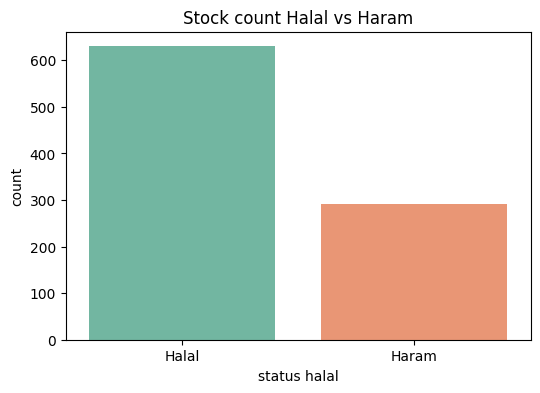

In [79]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='halal_status', palette='Set2')
plt.title('Stock count Halal vs Haram')
plt.xlabel('status halal')
plt.ylabel('count')
plt.show()